# 1. Preprocessing
Look through your data for outliers, perform standardization/normalization and handle missing values.  Use dimensionality reduction if your dataset has a lot of features.+

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Spring-2024/Big Data Science/hw5/Breast_Cancer_dataset.csv'

Mounted at /content/drive


In [48]:
# Read the CSV file
df = pd.read_csv(path)

print(len(df))

numerical_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate z-scores for numerical columns
z_scores = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()

# Identify outliers
outliers = (z_scores > 3) | (z_scores < -3)

# Count number of outliers
num_outliers = outliers.sum().sum()
print(f"Number of outliers: {num_outliers}")

# Replace outliers with None
df = df[~outliers.any(axis=1)]

df.reset_index(drop=True, inplace=True)

# Handle Missing Values
imputer = SimpleImputer(strategy='mean')
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
numerical_columns_imputed = imputer.fit_transform(numerical_columns)

# Standardization/Normalization
scaler = StandardScaler()  # or MinMaxScaler for normalization
numerical_columns_scaled = scaler.fit_transform(numerical_columns_imputed)

# Replace numerical columns in the original DataFrame with processed numerical columns
df[numerical_columns.columns] = numerical_columns_scaled


df.info()

4024
Number of outliers: 224
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3813 entries, 0 to 3812
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     3813 non-null   float64
 1   Race                    3813 non-null   object 
 2   Marital Status          3813 non-null   object 
 3   T Stage                 3813 non-null   object 
 4   N Stage                 3813 non-null   object 
 5   6th Stage               3813 non-null   object 
 6   differentiate           3813 non-null   object 
 7   Grade                   3813 non-null   object 
 8   A Stage                 3813 non-null   object 
 9   Tumor Size              3813 non-null   float64
 10  Estrogen Status         3813 non-null   object 
 11  Progesterone Status     3813 non-null   object 
 12  Regional Node Examined  3813 non-null   float64
 13  Reginol Node Positive   3813 non-null   float64
 14  Survival Mo

# 2. Modeling [15] – For this step you can use tools and/or libraries
Apply the Feature Selection and Feature Ranking Techniques we covered in class and/or a combination of both approaches.
Train the following algorithms on your dataset (feel free to experiment with more!)

NOTE: For each model used, be sure to include a 1-2 line summary as well as the pros and cons of each algorithm and list out its main hyperparameters.


## Feature Selection

In [49]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

df_encoded = pd.get_dummies(df)

X = df_encoded.iloc[:,0:15]  #independent columns
Y = df_encoded.iloc[:,-1]    #target column
print(Y)

# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,Y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  # Naming the dataframe columns

top_10_features = featureScores.nlargest(10,'Score')  # Get 10 best features
print(top_10_features)

# Create a new dataframe with only the top 10 features
df_top_10 = df_encoded[top_10_features['Specs'].values]


0       False
1       False
2       False
3       False
4       False
        ...  
3808    False
3809    False
3810    False
3811    False
3812    False
Name: Status_Dead, Length: 3813, dtype: bool
                       Specs     Score
4            Survival Months  0.126997
3      Reginol Node Positive  0.020227
1                 Tumor Size  0.016960
13               T Stage _T1  0.008197
5                 Race_Black  0.007908
8    Marital Status_Divorced  0.006258
9     Marital Status_Married  0.002490
2     Regional Node Examined  0.002370
12    Marital Status_Widowed  0.002085
10  Marital Status_Separated  0.001548


# 2.1	KNN (this should be implemented from scratch, do NOT use in-built libraries)

In [58]:
import numpy as np

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # Compute distances between x and all examples in the training set
        distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]
        # Sort by distance and return indices of the first k neighbors
        k_indices = np.argsort(distances)[:self.k]
        # Extract the labels of the k nearest neighbor training samples
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # return the most common class label
        most_common = max(set(k_nearest_labels), key=k_nearest_labels.count)
        return most_common


In [60]:
for col in df_top_10.columns:
    if df_top_10[col].dtype == bool:
        df_top_10[col] = df_top_10[col].astype(int)

Y = Y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(df_top_10, Y, test_size=0.2, random_state=42)

# Create an instance of KNN
knn = KNN(k=3)

# Fit the model to the training data
knn.fit(X_train.values, y_train.values)

# Make predictions on the test data
predictions = knn.predict(X_test.values)

In [62]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

print(f'Accuracy: {accuracy(y_test, predictions)*100:.2f}%')

Accuracy: 88.47%


 Pros and Cons: KNN is simple to understand and implement, and it doesn’t require any training phase. However, it can be computationally expensive and slow for large datasets, and its performance can be significantly impacted by the choice of the distance metric and the value of K.

 Main Hyperparameters: K

# 2.2 Naïve Bayes

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder


#X = df.drop('Status', axis=1)  # Feature columns
#y = Y
X = df_top_10
y = Y


categorical_cols = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Drop first category to avoid multicollinearity
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]))
X_encoded.columns = encoder.get_feature_names_out(categorical_cols)
X.drop(categorical_cols, axis=1, inplace=True)
X = pd.concat([X, X_encoded], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes classifier (assuming the feature column is categorical)
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8768020969855832


<ipython-input-26-f4082e81989e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(categorical_cols, axis=1, inplace=True)


Pros and Cons: Naive Bayes is fast, easy to implement, and performs well with high-dimensional datasets. However, its assumption of feature independence is often violated in real-world data, which can negatively impact its performance.

Main Hyperparameters: Alpha

# 2.3 C4.5 Decision Tree

In [69]:
pip install c45-decision-tree

In [82]:
from C45 import C45Classifier
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(df_top_10, Y, test_size=0.2, random_state=42)
model = C45Classifier()
model.fit(X_train, y_train)
model.evaluate(X_test, y_test)

Evaluation result: 
Total accuracy:  0.7352555701179554
Accuracy  0 :  0.746177370030581
Accuracy  1 :  0.6697247706422018


Pros and Cons:  C4.5 can handle both categorical and continuous data, and it uses a post-pruning approach to avoid overfitting. However, it can be sensitive to small changes in the data, leading to different trees, and it may not perform well with unbalanced datasets.

Main Hyperparameter: Criterion and max_depth

# 2.4 Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_top_10.values
y = Y.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier and fit it to the training data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Print the accuracy
print(f'Accuracy: {accuracy(y_test, y_pred)*100:.2f}%')


Accuracy: 89.91%


Pros and Cons: Random Forest is robust to overfitting and can handle large datasets with high dimensionality. However, it can be computationally intensive and slower to train and predict than simpler models, and it may not perform well with very sparse data or datasets with many categorical variables.

Main Hyperparameters: n_estimators, criterion, max_depth

# 2.5 Gradient Boosting

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X = df_top_10.values
y = Y.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a gradient boosting classifier and fit it to the training data
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Print the accuracy
print(f'Accuracy: {accuracy(y_test, y_pred)*100:.2f}%')

Accuracy: 90.43%


Pros and Cons: Gradient Boosting can provide high predictive accuracy and is effective with unbalanced datasets. However, it can be prone to overfitting if not properly regularized, and it can be more computationally intensive and slower to train than other models.

Main Hyperparameter: n_estimators, learning_rate, max_depth

# 3 Hyperparameter Tuning

In [81]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

X = df_top_10.values
y = Y.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5)

# Fit the GridSearchCV object to the data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters for RandomForestClassifier: ", grid_search_rf.best_params_)
print("Best score for RandomForestClassifier: ", grid_search_rf.best_score_)

# Predict on the test data and print the performance metrics
y_pred_rf = grid_search_rf.predict(X_test)
print("Performance metrics for RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))

# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [1, 3, 5]
}

# Create a GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42)

# Create the GridSearchCV object for GradientBoostingClassifier
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5)

# Fit the GridSearchCV object to the data
grid_search_gb.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters for GradientBoostingClassifier: ", grid_search_gb.best_params_)
print("Best score for GradientBoostingClassifier: ", grid_search_gb.best_score_)

# Predict on the test data and print the performance metrics
y_pred_gb = grid_search_gb.predict(X_test)
print("Performance metrics for GradientBoostingClassifier:")
print(classification_report(y_test, y_pred_gb))


Best parameters for RandomForestClassifier:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best score for RandomForestClassifier:  0.9036065573770491
Performance metrics for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       654
           1       0.77      0.50      0.61       109

    accuracy                           0.91       763
   macro avg       0.85      0.74      0.78       763
weighted avg       0.90      0.91      0.90       763

Best parameters for GradientBoostingClassifier:  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}
Best score for GradientBoostingClassifier:  0.9022950819672131
Performance metrics for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       654
           1       0.73      0.51      0.60       109

    accuracy                           0.90   

Hyperparameter Tuning Results:

Best parameters for RandomForestClassifier:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Best score for RandomForestClassifier:  0.9036065573770491

Best parameters for GradientBoostingClassifier:  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 200}

Best score for GradientBoostingClassifier:  0.9022950819672131


# Results

In [84]:
results = {
    'Algorithm Name': ['KNN', 'Naive Bayes', 'C4.5', 'Random Forest', 'Gradient Boosting'],
    'Accuracies': ['88.74%', '87.68%', '73.54%', '89.91%', '90.43%']
}

# Create the DataFrame
results = pd.DataFrame(results)
results

,Algorithm Name,Accuracies
0,KNN,88.74%
1,Naive Bayes,87.68%
2,C4.5,73.54%
3,Random Forest,89.91%
4,Gradient Boosting,90.43%


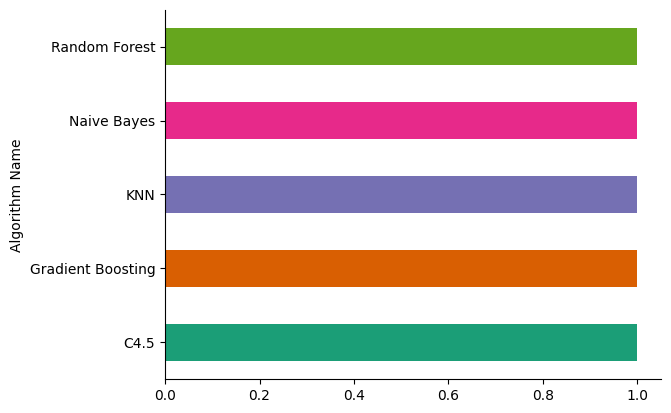

In [86]:
from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('Algorithm Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We were certainly able to achieve our initial goal of developing a predictive model that can accurately classify patients into survivability outcomes based on a set of features derived from the SEER database. Each of our models performed relatively well with a minimum accuracy score of 73.54, maximum accuracy score of 90.43%, and four of the five algorithms having an accuracy higher than 87%. Overall, we are proud of our results.